<a href="https://colab.research.google.com/github/annms1/Heart-attack-dataset/blob/main/Heart_Attack_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the necessary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import missingno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import LearningRateScheduler

In [3]:
# Reading the dataset
dataset = pd.read_csv("Heart Attack Data Set.csv")
print(dataset.describe())
dataset

              age         sex          cp  ...          ca        thal      target
count  303.000000  303.000000  303.000000  ...  303.000000  303.000000  303.000000
mean    54.366337    0.683168    0.966997  ...    0.729373    2.313531    0.544554
std      9.082101    0.466011    1.032052  ...    1.022606    0.612277    0.498835
min     29.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%     47.500000    0.000000    0.000000  ...    0.000000    2.000000    0.000000
50%     55.000000    1.000000    1.000000  ...    0.000000    2.000000    1.000000
75%     61.000000    1.000000    2.000000  ...    1.000000    3.000000    1.000000
max     77.000000    1.000000    3.000000  ...    4.000000    3.000000    1.000000

[8 rows x 14 columns]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


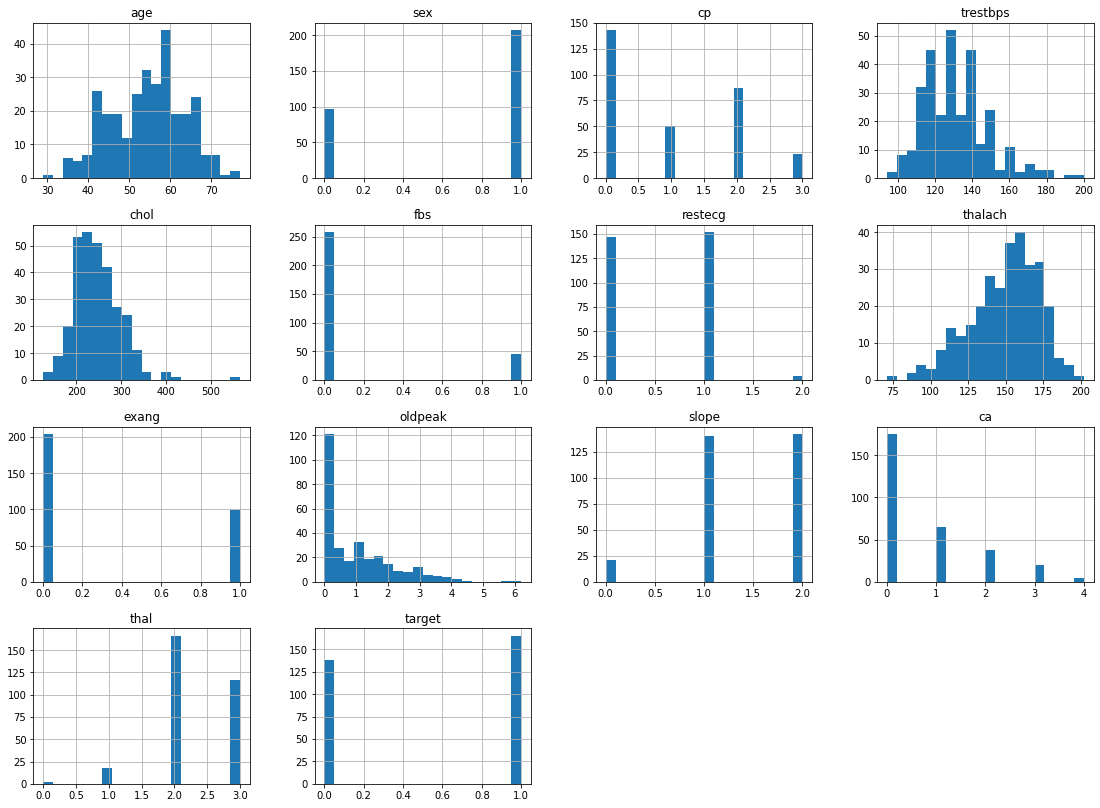

In [4]:
# Visualizing the data
dataset.hist(bins=20, figsize=(19, 14))
plt.show()

In [5]:
categorical = ["sex", "cp",	"fbs", "restecg", "exang", "target"]
numerical = ["age", "trestbps", "chol", "thalach", "oldpeak", "slope", "ca", "thal"]

In [105]:
ct_MM = make_column_transformer(
    (MinMaxScaler(), numerical),
    remainder="passthrough")

In [211]:
# Normalizing the numerical data to make it easier for the model to learn them
dataset_MM = ct_MM.fit_transform(dataset)
dataset_MM = pd.DataFrame(dataset_MM, columns=numerical + categorical)
dataset_MM

,age,trestbps,chol,thalach,oldpeak,slope,ca,thal,sex,cp,fbs,restecg,exang,target
0,0.708333,0.481132,0.244292,0.603053,0.370968,0.0,0.00,0.333333,1.0,3.0,1.0,0.0,0.0,1.0
1,0.166667,0.339623,0.283105,0.885496,0.564516,0.0,0.00,0.666667,1.0,2.0,0.0,1.0,0.0,1.0
2,0.250000,0.339623,0.178082,0.770992,0.225806,1.0,0.00,0.666667,0.0,1.0,0.0,0.0,0.0,1.0
3,0.562500,0.245283,0.251142,0.816794,0.129032,1.0,0.00,0.666667,1.0,1.0,0.0,1.0,0.0,1.0
4,0.583333,0.245283,0.520548,0.702290,0.096774,1.0,0.00,0.666667,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.583333,0.433962,0.262557,0.396947,0.032258,0.5,0.00,1.000000,0.0,0.0,0.0,1.0,1.0,0.0
299,0.333333,0.150943,0.315068,0.465649,0.193548,0.5,0.00,1.000000,1.0,3.0,0.0,1.0,0.0,0.0
300,0.812500,0.471698,0.152968,0.534351,0.548387,0.5,0.50,1.000000,1.0,0.0,1.0,1.0,0.0,0.0
301,0.583333,0.339623,0.011416,0.335878,0.193548,0.5,0.25,1.000000,1.0,0.0,0.0,1.0,1.0,0.0


In [212]:
# Turning label encoded variables to one-hot encoded variables(if value_counts is more than 2)
cat = OneHotEncoder().fit_transform(dataset[["cp", "restecg"]])
import scipy.sparse
cat = pd.DataFrame.sparse.from_spmatrix(cat, columns=["cp_0", "cp_1", "cp_2", "cp_3", "restecg_0", "restecg_1", "restecg_2"])
dataset_MM = pd.concat([dataset_MM.drop(["cp", "restecg"], axis=1), cat], axis=1)
dataset_MM.drop("restecg_2", axis=1, inplace=True)
dataset_MM

In [213]:
X_MM = dataset_MM.drop("target", axis=1)
y_MM = dataset_MM["target"]
X_train_MM, X_test_MM, y_train_MM, y_test_MM = train_test_split(X_MM, y_MM, test_size=0.17, random_state=42)

In [222]:
# Creating an exponential decay learning rate scheduler to decrease learning rate every epoch exponentially
initial_lr = 0.0014
decay_rate = 0.0015
def exp_decay(epoch):
    lrate = initial_lr * np.exp(-decay_rate * epoch)
    return lrate
lrs = LearningRateScheduler(exp_decay)
callback = [lrs]

In [231]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
                     tf.keras.layers.Dense(80, activation="relu"),
                     tf.keras.layers.Dense(75, activation="relu"),
                     tf.keras.layers.Dense(50, activation="relu"),
                     tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history = model.fit(X_train_MM, y_train_MM, epochs=40, callbacks=callback)

Epoch 1/40
8/8 [==============================] - 1s 3ms/step - loss: 0.6602 - accuracy: 0.6295 - lr: 0.0013
Epoch 2/40
8/8 [==============================] - 0s 3ms/step - loss: 0.5919 - accuracy: 0.7769 - lr: 0.0013
Epoch 3/40
8/8 [==============================] - 0s 3ms/step - loss: 0.5199 - accuracy: 0.7968 - lr: 0.0013
Epoch 4/40
8/8 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.7928 - lr: 0.0013
Epoch 5/40
8/8 [==============================] - 0s 3ms/step - loss: 0.4236 - accuracy: 0.8167 - lr: 0.0013
Epoch 6/40
8/8 [==============================] - 0s 3ms/step - loss: 0.3982 - accuracy: 0.8088 - lr: 0.0013
Epoch 7/40
8/8 [==============================] - 0s 3ms/step - loss: 0.3819 - accuracy: 0.8367 - lr: 0.0013
Epoch 8/40
8/8 [==============================] - 0s 2ms/step - loss: 0.3626 - accuracy: 0.8486 - lr: 0.0013
Epoch 9/40
8/8 [==============================] - 0s 3ms/step - loss: 0.3513 - accuracy: 0.8526 - lr: 0.0013
Epoch 10/40
8/8 [==

In [232]:
model.evaluate(X_test_MM, y_test_MM)

2/2 [==============================] - 0s 6ms/step - loss: 0.5881 - accuracy: 0.8462


[0.5881229639053345, 0.8461538553237915]

In [94]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'lr'])

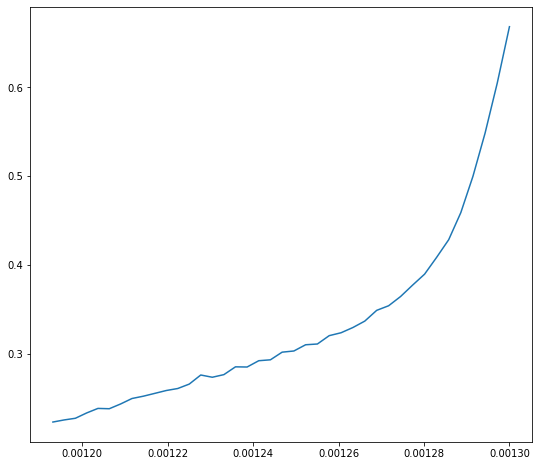

In [230]:
# Visualizing the model's loss relative to its learning rate
plt.figure(figsize=(9, 8))
plt.plot(history.history["lr"], history.history["loss"])
plt.show()

In [234]:
y_preds = model.predict(X_test_MM)

In [235]:
# Rounding the input to 1 if it is over 0.5 and 0 if it is under 0.5
# because confusion matrices and classification reports cannot understand numerical data
y_preds_rounded = np.round(y_preds)

In [236]:
confusion_matrix(y_test_MM, y_preds_rounded)

array([[19,  4],
       [ 4, 25]])

In [237]:
print(classification_report(y_test_MM, y_preds_rounded))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        23
         1.0       0.86      0.86      0.86        29

    accuracy                           0.85        52
   macro avg       0.84      0.84      0.84        52
weighted avg       0.85      0.85      0.85        52

